## musicntwrk - advanced score analysis and harmonic design

 A python library for pitch class set and rhythmic sequences classification and manipulation,
 the generation of networks in generalized musical spaces, and the sonification of arbitrary data
 See documentation at www.musicntwrk.com 

 Copyright (C) 2018,2019,2020 Marco Buongiorno Nardelli
 http://www.materialssoundmusic.com, mbn@unt.edu

 This file is distributed under the terms of the
 GNU General Public License. See the file `License'
 in the root directory of the present distribution,
 or http://www.gnu.org/copyleft/gpl.txt .

For a high quality graphics representation of networks, node and edge files can be written to disk in csv format and directly imported in visualization programs like Gephi (www.gephi.org)

To display musicxml in notation format a notation app should be installed (see for instance www.musescore.org) and should be defined in music21 preferences (see https://web.mit.edu/music21/doc/usersGuide/usersGuide_08_installingMusicXML.html)

#### Installation

pip install musicntwrk  
or  
pip install musicntwrk[with_MPI]  
(if there is a pre-existing installation of MPI, pip will automatically install the mpi4pi wrapper)

In [1]:
import re, sys, os, time
from musicntwrk import musicntwrk
from musicntwrk.plotting.drawNetwork import drawNetwork
mk = musicntwrk.musicntwrk(TET=12)

#### Anaysis of J.S. Bach chorale from BWV267 with partitioning and subnetworks
musicxml file from music21 corpus

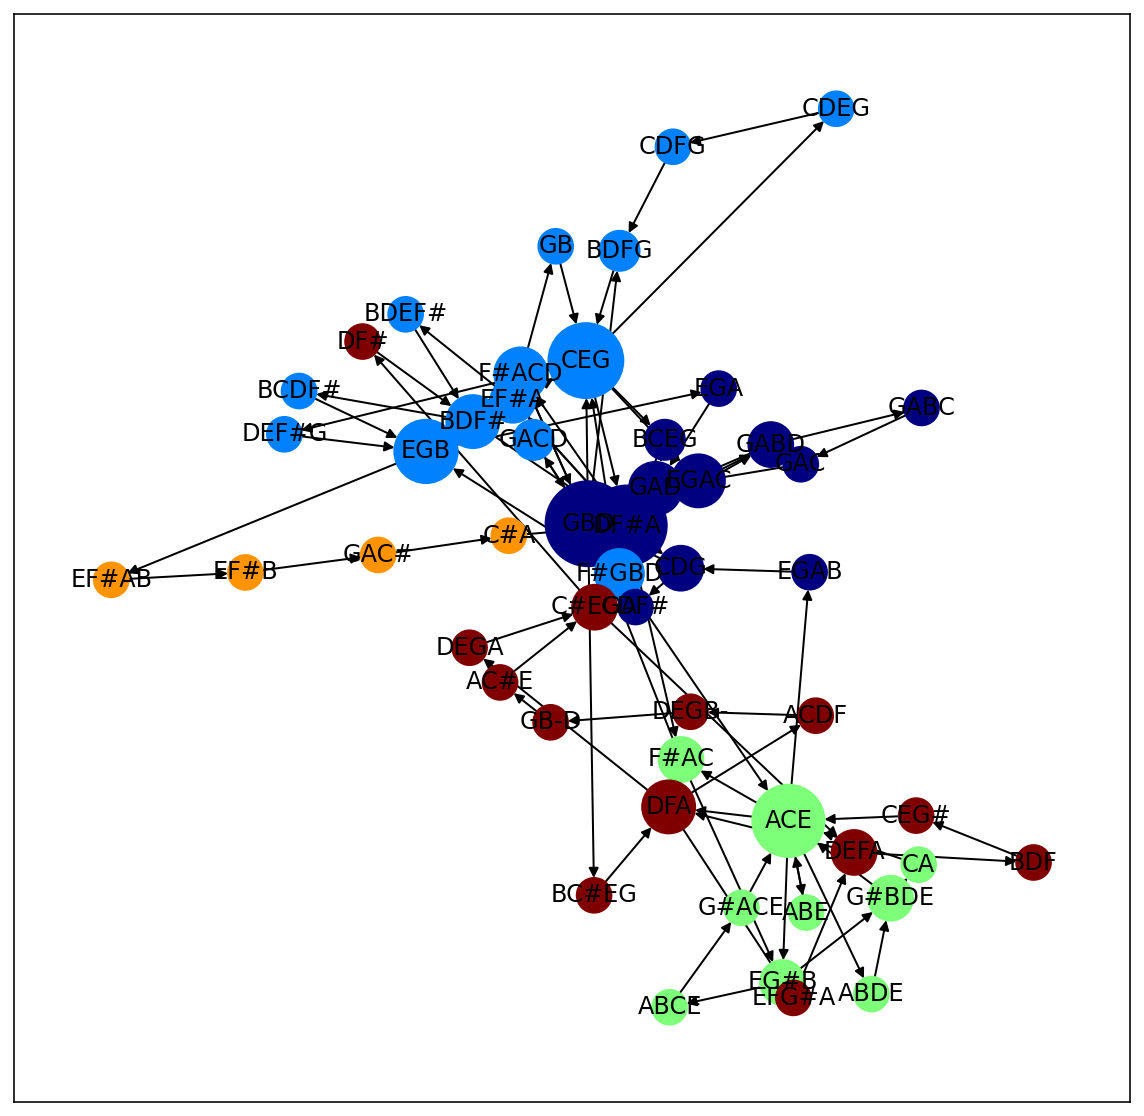

In [72]:
import music21 as m21
bachChorale = m21.corpus.parse('bwv267').corpusFilepath
seq,chords,_ = mk.dictionary(space='score',scorefil=bachChorale,music21=True,show=False)
bnodes,bedges,_,_,_,_,_ = mk.network(space='score',seq=seq,ntx=True,general=True,distance='euclidean',
                                   grphtype='directed')
drawNetwork(bnodes,bedges,grphtype='directed')

In [3]:
from musicntwrk.plotting.plotOpsHistogram import plotOpsHistogram

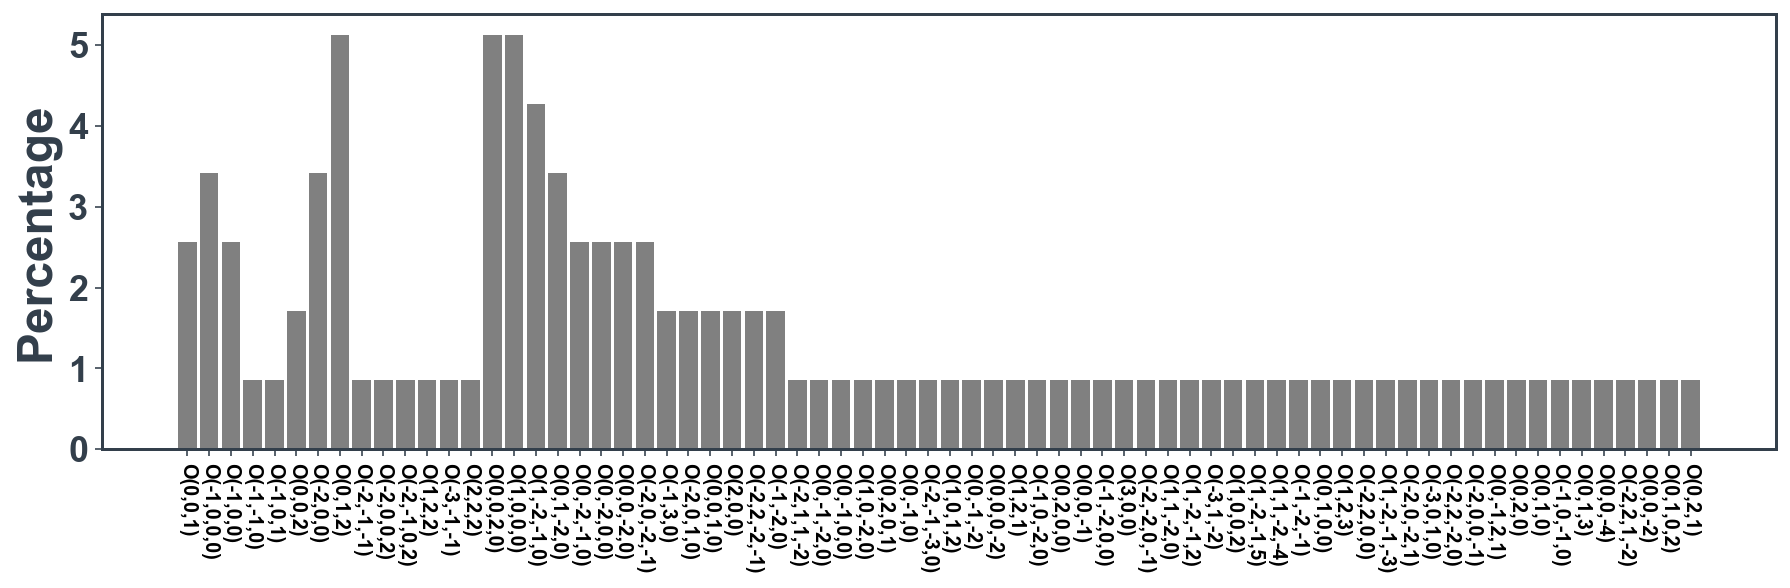

In [4]:
plotOpsHistogram(bedges)

#### filter out low recurring chords to facilitate change point detection and score partitioning in regions

In [5]:
from musicntwrk.harmony.scoreFilter import scoreFilter

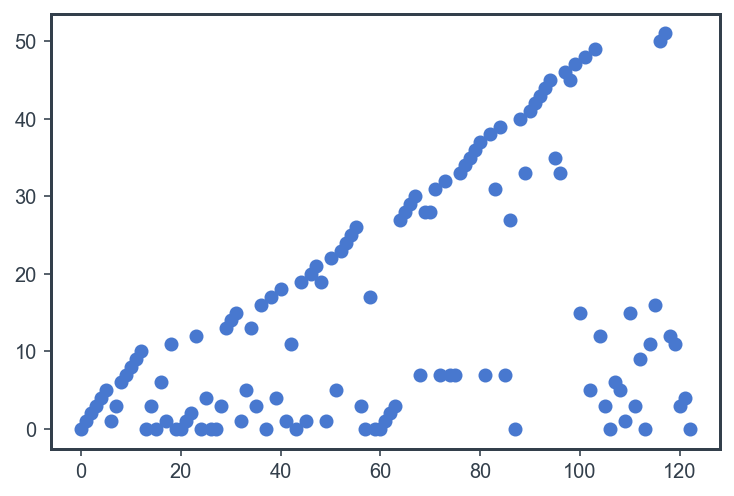

total number of chords =  123


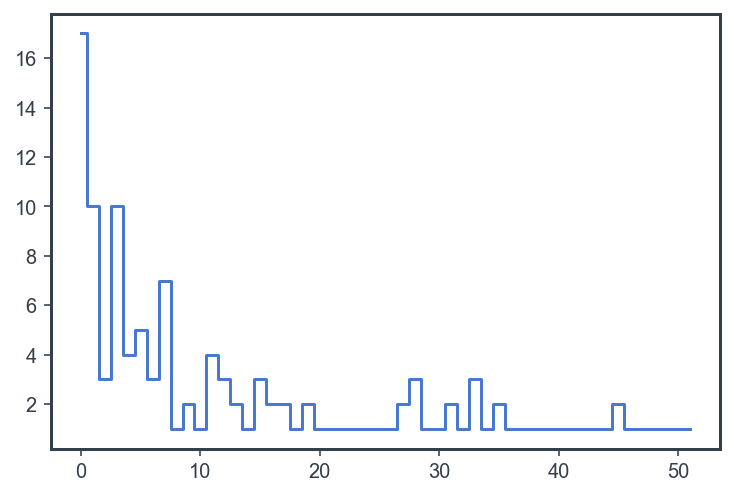

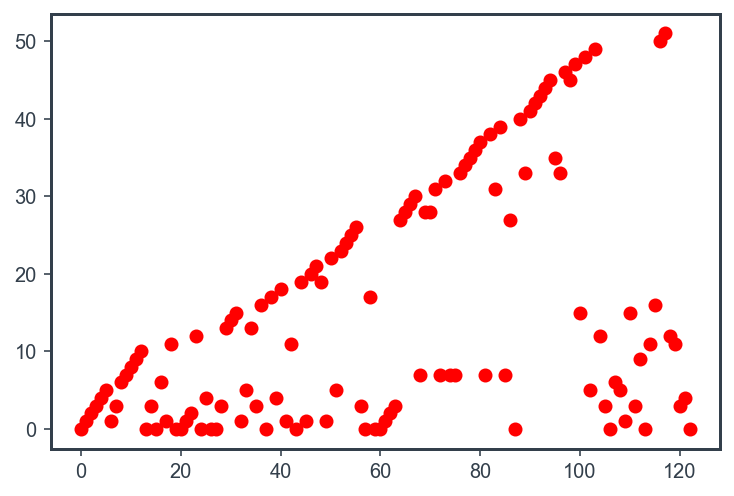

total number of filtered chords =  123


In [6]:
value,valuef,filtered,fmeasure = scoreFilter(seq,chords,thr=0,plot=True)

#### run a change point detection algorithm to isolate sections

In [7]:
from musicntwrk.harmony.changePoint import changePoint

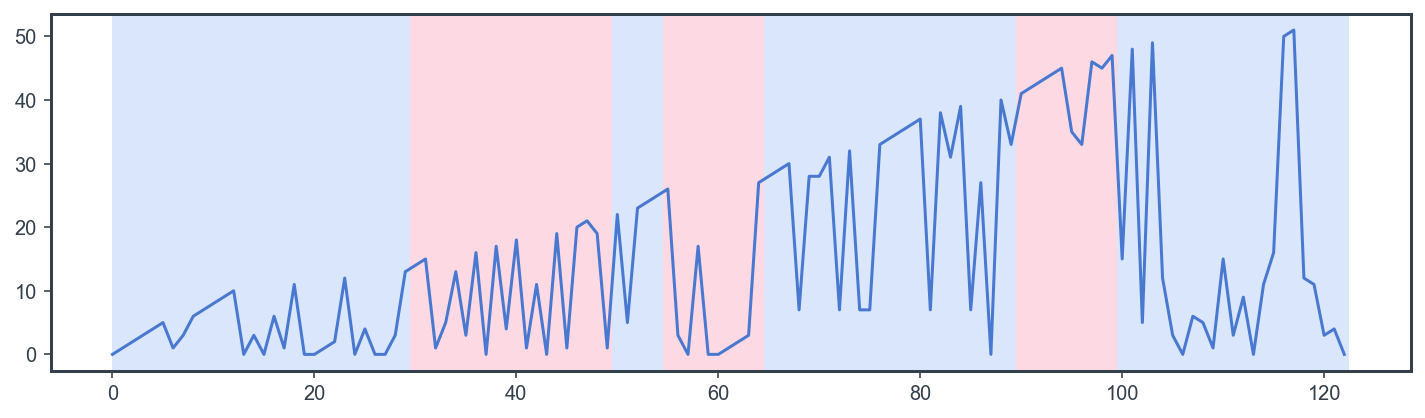

model =  rbf  - sections =  [0, 30, 50, 55, 65, 90, 100, 122]


In [8]:
sections = changePoint(valuef,penalty=1.0,plot=True)

#### Build networks from regions

In [9]:
GxsecDi = []
for n in range(len(sections)-1):
    nodes,edges,_,_,_,Gx,_ = mk.network(space='score',sub=True,seq=seq,start=sections[n],end=sections[n+1],
                                        ntx=True,general=True,distance='euclidean',grphtype='directed')
    GxsecDi.append(Gx)

#### region key identification

In [10]:
from musicntwrk.harmony.keySections import keySections

In [11]:
key,keySections = keySections(sections,GxsecDi,nodes)

In [12]:
keySections

,Section,chord range,prevalent_chord,region
0,0,0-30,"['G', 'B', 'D']",G
0,1,30-50,"['C', 'E', 'G']",C
0,2,50-55,"['E', 'G', 'B']",e
0,3,55-65,"['G', 'B', 'D']",G
0,4,65-90,"['A', 'C', 'E']",a
0,5,90-100,"['C#', 'E', 'G', 'A']",D
0,6,100-122,"['D', 'F#', 'A']",D


#### roman numeral analysis of regions

In [13]:
from musicntwrk.harmony.tonalAnalysis import tonalAnalysis

In [14]:
analysis = tonalAnalysis(chords,sections,key,enharm=[['C','C']],write=True)

In [15]:
analysis

,pcs,chord,rn,ops,region
0,"[7, 11, 7, 2]","[G, B, G, D]",I,"O(0,1,2)",G
1,"[0, 0, 7, 4]","[C, C, G, E]",IV,"O(0,0,0,-1)",G
2,"[0, 11, 7, 4]","[C, B, G, E]",IV7,"O(-2,2,-2,-1)",G
3,"[2, 9, 6, 2]","[D, A, F#, D]",V,"O(0,0,0,-2)",G
4,"[2, 9, 6, 0]","[D, A, F#, C]",V7,"O(1,-2,-1,2)",G
...,...,...,...,...,...
118,"[2, 2, 7, 9]","[D, D, G, A]",iv54,"O(2,0,0,-2)",D
119,"[0, 4, 7, 9]","[C, E, G, A]",v65,"O(-2,-1,0,2)",D
120,"[2, 2, 6, 9]","[D, D, F#, A]",I,"O(0,0,0,-2)",D
121,"[2, 0, 6, 9]","[D, C, F#, A]",Ib753,"O(1,-2,-1,0)",D


#### compositional design of (pseudo) tonal networks 
__part I__: Bach's chord distribution on a scale-free network built according to the Barabasi-Albert model of preferential attachment

In [43]:
from musicntwrk.harmony.harmonicDesign import harmonicDesign

Number of nodes (odd): 16
Number of edges (odd): 120
Number of edges in matching: 8
Length of Eulerian circuit: 111


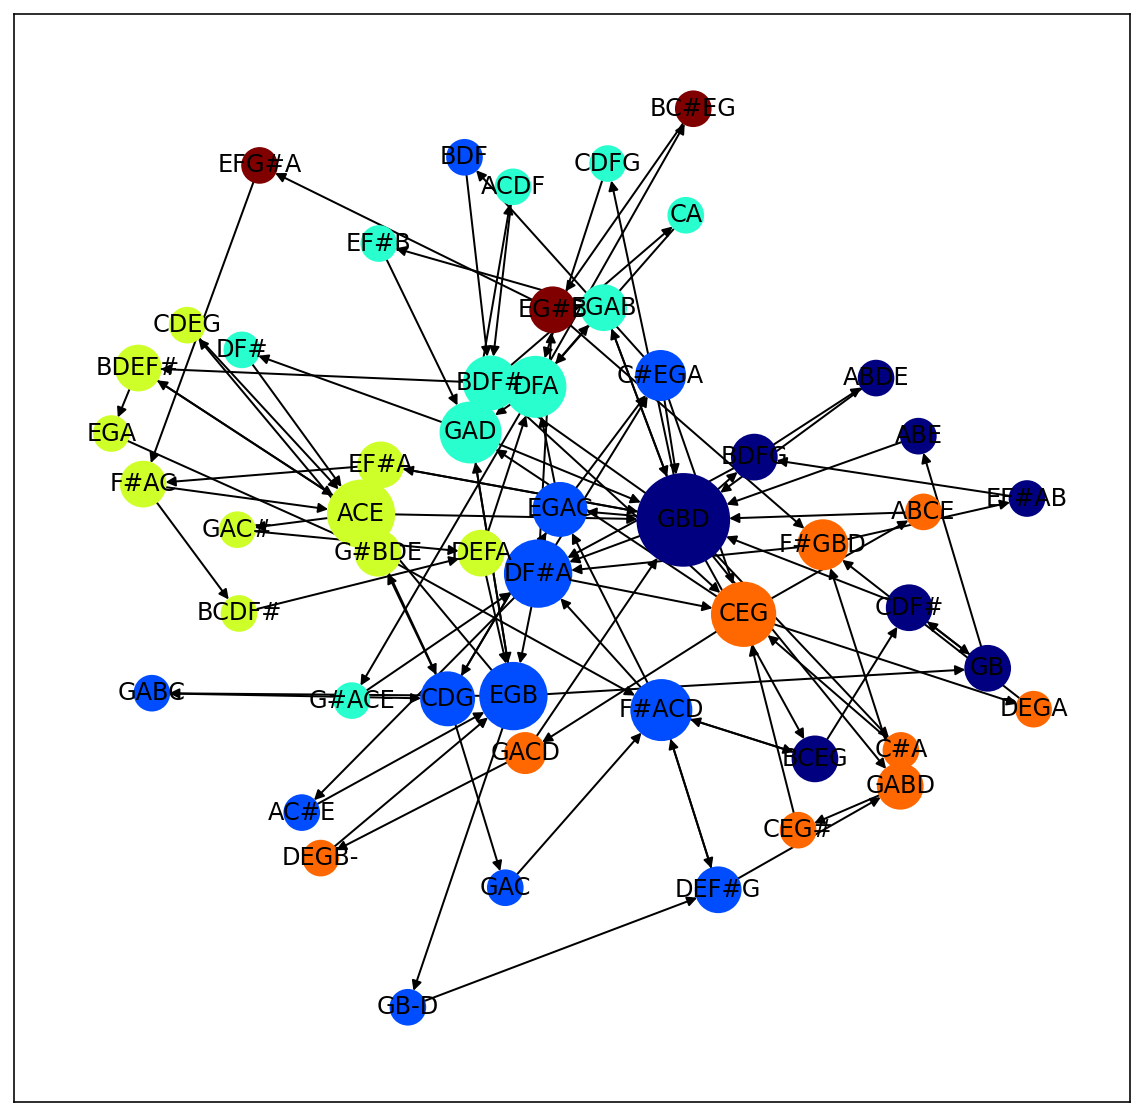

In [5]:
euseq = harmonicDesign(mk,len(bnodes),2,bnodes,bedges,seed=10,reverse=True,display=True,write=True)

__part II__: probabilistic chord distribution based on voice leading distances on a scale-free network built according to the Barabasi-Albert model of preferential attachment

In [26]:
# generate initial dictionary of tetrachords
tetra,_ = mk.dictionary(space='pcs',Nc=4,row=False,order=1,prob=0.15)

In [59]:
import pandas as pd
import networkx as nx
import numpy as np

In [50]:
# generation of probabilistic complex network with operatorial design
dnodes,dedges_1 = mk.network(space='vLead',vector=True,ops=True,name='O(1)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.15,write=False)
_,dedges_11 = mk.network(space='vLead',vector=True,ops=True,name='O(1,1)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.11,write=False)
_,dedges_112 = mk.network(space='vLead',vector=True,ops=True,name='O(1,1,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.09,write=False)
_,dedges_12 = mk.network(space='vLead',vector=True,ops=True,name='O(1,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.23,write=False)
_,dedges_1122 = mk.network(space='vLead',vector=True,ops=True,name='O(1,1,2,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.06,write=False)
_,dedges_122 = mk.network(space='vLead',vector=True,ops=True,name='O(1,2,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.06,write=False)
_,dedges_1222 = mk.network(space='vLead',vector=True,ops=True,name='O(1,2,2,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.46,write=False)
_,dedges_113 = mk.network(space='vLead',vector=True,ops=True,name='O(1,1,3)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.04,write=False)
_,dedges_111 = mk.network(space='vLead',vector=True,ops=True,name='O(1,1,1)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.02,write=False)
_,dedges_22 = mk.network(space='vLead',vector=True,ops=True,name='O(2,2)',
                             dictionary=tetra,thup=1.5,thdw=0.1,distance='euclidean',prob=0.02,write=False)

dedges = pd.DataFrame(None,columns=['Source','Target','Weight','Label'])
dedges = dedges.append(dedges_1)
dedges = dedges.append(dedges_11)
dedges = dedges.append(dedges_112)
dedges = dedges.append(dedges_12)
dedges = dedges.append(dedges_1122)
dedges = dedges.append(dedges_122)
dedges = dedges.append(dedges_1222)
dedges = dedges.append(dedges_113)
dedges = dedges.append(dedges_111)
dedges = dedges.append(dedges_22)

In [68]:
df = np.asarray(tetra)
dnodes = pd.DataFrame(df[:,1],columns=['pcs'])

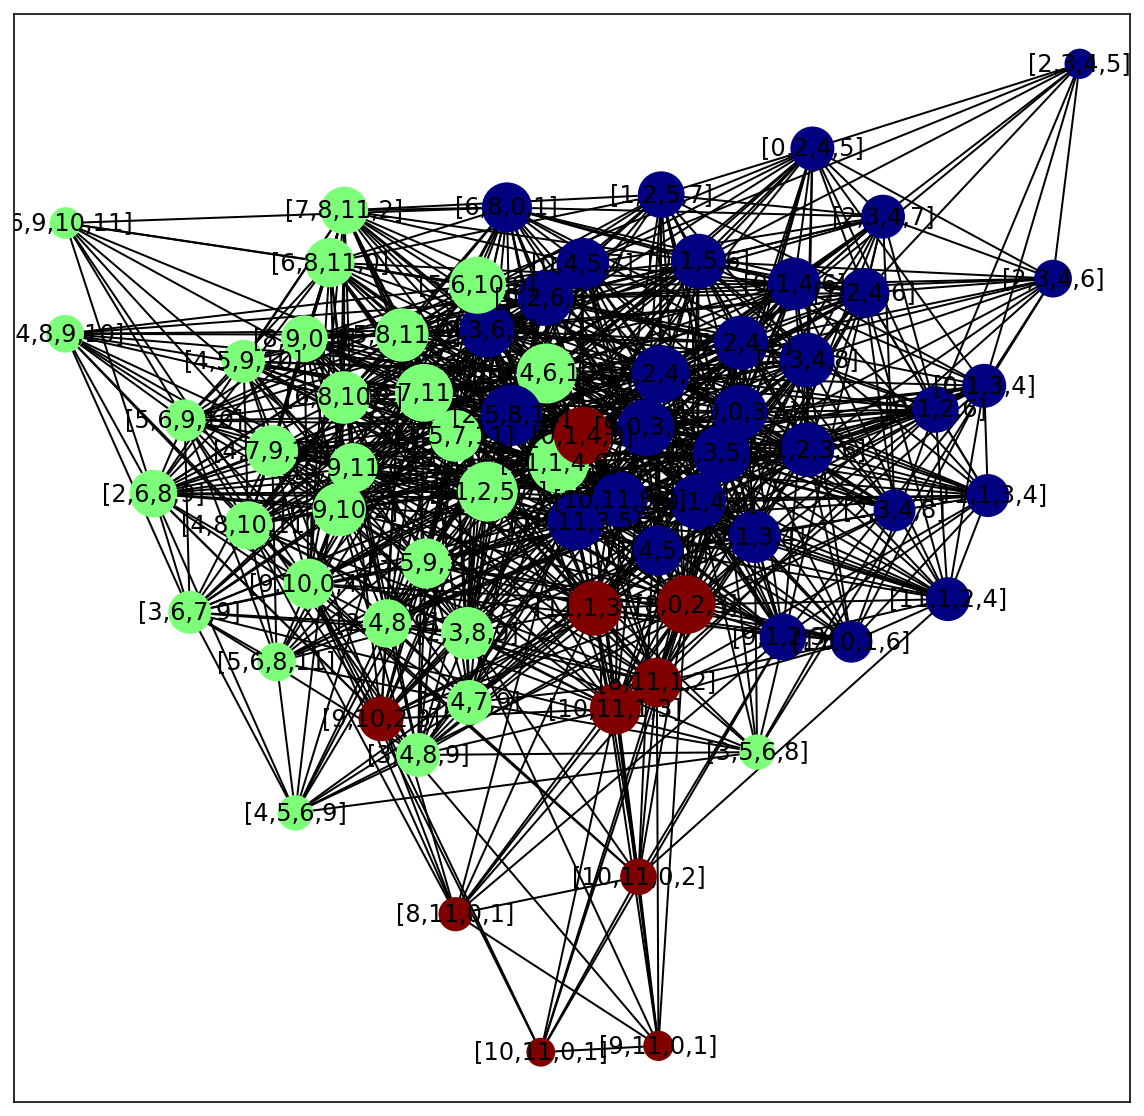

In [69]:
drawNetwork(dnodes,dedges,scale=0.2)

In [70]:
euseq = harmonicDesign(mk,len(dnodes),2,dnodes,dedges,seed=10,reverse=True,display=True,write=True)

Number of nodes (odd): 24
Number of edges (odd): 276
Number of edges in matching: 12
Length of Eulerian circuit: 156


PitchException: Cannot make a step out of '['

In [73]:
bnodes

,Label
0,ABCE
0,ABDE
0,ABE
0,AC#E
0,ACDF
0,ACE
0,BC#EG
0,BCDF#
0,BCEG
0,BDEF#
